This notebook estimates the curve shape relating a feature of interest (e.g. word surprisal) and average/peak amplitude for the given ERPs, given a trained Cannon model.

In [67]:
import io
from itertools import product
import logging
L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import torch
from tqdm.auto import tqdm

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import sys
sys.path.append("..")
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.eeg import load_eeg_dataset
from berp.models import load_model
import berp.trainer  # good yaml defaults
from berp.viz.trf import plot_trf_coefficients
from berp.viz.trf_em import pipeline_to_dataframe, aggregate_cannon_coef_df

In [70]:
workflow = "heilbron2022"
lm = "EleutherAI/gpt-neo-2.7B/n10000"

paradigm = "cannon_wide"
# cannon_run_name = "trf-berp-cannon_3quantiles"
# cannon_run_name = "trf-berp-cannon_4quantiles"
cannon_run_name = "trf-cannon_5quantiles"

# Safe to load just one subject -- we only are investigating stimulus differences here
subjects = [1]
runs = list(range(1, 20))
stories = ["old-man-and-the-sea"]

# target_sensors = ["B19", "B20", "B22"]
target_sensors = ['B22', 'D19', 'A19', 'C22', 'C10', 'C32', 'A7', 'B4']

normalize_X_ts = False
normalize_X_variable = True
normalize_Y = False

temporal_rois = [("n125", 0.125 - 0.05, 0.125 + 0.05, "idxmin"),
                 ("n400", 0.35, 0.45, "idxmin")]
test_features = ["var_word_surprisal"]

In [71]:
model_dir = f"../workflow/{workflow}/results_{paradigm}/{lm}/{cannon_run_name}"
dataset_dir = f"../workflow/{workflow}/data/dataset/{lm}"
stimulus_dir = f"../workflow/{workflow}/data/stimulus/{lm}"

## Prepare dataset

In [72]:
# Load datasets.
ds = {}
stimulus_paths = {f"{story}/run{run}": Path(stimulus_dir) / f"{story}/run{run}.pkl"
                  for story in stories for run in runs}
combs = list(product(stories, subjects, runs))
ds_paths = []
for story, subject, run in tqdm(combs):
    ds_path = Path(dataset_dir) / story / f"sub{subject}" / f"run{run}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue
    ds_paths.append(ds_path)
    
nested_ds = load_eeg_dataset(
    ds_paths,
    subset_sensors=target_sensors,
    stimulus_paths=stimulus_paths,
    normalize_X_ts=normalize_X_ts, 
    normalize_X_variable=normalize_X_variable, 
    normalize_Y=normalize_Y)

assert len(combs) == len(nested_ds.datasets)
ds = dict(zip(combs, nested_ds.datasets))

  0%|          | 0/19 [00:00<?, ?it/s]

## Load pipeline

In [73]:
pipe = load_model(model_dir, device="cpu")

In [74]:
yaml.safe_dump(pipe.get_params(), sys.stdout)

confusion: tensor of type torch.float64, shape torch.Size([40, 40])
encoder: "TemporalReceptiveField(alpha=55139.793175091734, fit_intercept=True,\n \
  \                      name='5a7e5adb190b431e811274533c0605c9',\n              \
  \         optim=AdamSolver(n_batches=50,\n                                     \
  \   name='5a7e5adb190b431e811274533c0605c9',\n                                 \
  \       random_state=RandomState(MT19937) at 0x2B13FB97DD40),\n                \
  \       sfreq=128.0, tmax=0.75, tmin=0.0)"
encoder__alpha: 55139.793175091734
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: null
encoder__name: 5a7e5adb190b431e811274533c0605c9
encoder__optim: "AdamSolver(n_batches=50, name='5a7e5adb190b431e811274533c0605c9',\n\
  \           random_state=RandomState(MT19937) at 0x2B13FB97DD40)"
encoder__optim__batch_size: 512
encoder__optim__early_stopping: 5
encoder__optim__learning_rate: 0.01
encoder__optim__n_batches: 50
encoder__optim__name: 5a

## Prepare model estimates

### Get coefficients

In [75]:
coef_df = pipeline_to_dataframe(pipe)
coef_agg_df = aggregate_cannon_coef_df(coef_df, pipe)

In [76]:
coef_agg_df

,base_predictor,subject,lag,epoch_time,sensor,quantile,coef,predictor_name
1,var_recognition_onset,1,0,0.00,0,0,0.000054,var_recognition_onset_1
2,var_recognition_onset,1,0,0.00,0,1,0.000015,var_recognition_onset_2
3,var_recognition_onset,1,0,0.00,0,2,0.000029,var_recognition_onset_3
4,var_recognition_onset,1,0,0.00,0,3,0.000152,var_recognition_onset_4
5,var_recognition_onset,1,0,0.00,0,4,-0.000045,var_recognition_onset_5
...,...,...,...,...,...,...,...,...
265387,var_word_surprisal,9,96,0.75,7,0,-0.000342,var_word_surprisal_1
265388,var_word_surprisal,9,96,0.75,7,1,-0.000153,var_word_surprisal_2
265389,var_word_surprisal,9,96,0.75,7,2,-0.000104,var_word_surprisal_3
265390,var_word_surprisal,9,96,0.75,7,3,-0.000182,var_word_surprisal_4


### Compute Berp posterior

In [77]:
# Just analyze one subject per run -- there are no differences between subjects in this analysis
all_runs = {f"{story}/run{run}": ds for (story, subject, run), ds in ds.items()}

In [78]:
df = berp.viz.trf_em.get_cannon_posterior_df(pipe, all_runs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1742.24dataset/s]


In [79]:
df

recognition_quantile  word_length  \
dataset                   word_idx                                      
old-man-and-the-sea/run1  0                            2            3   
                          1                            1            2   
                          2                            1            3   
                          3                            3            3   
                          4                            2            2   
...                                                  ...          ...   
old-man-and-the-sea/run19 584                          1            4   
                          585                          3            2   
                          586                          3            2   
                          587                          2            2   
                          588                          1            7   

                                    word_duration  word_surprisal  \
dataset                   word_idx                                  
old-man-and-the-sea/run1  0              0.156250       -2.381337   
                          1              0.078125       -3.896170   
                          2              0.289062       -3.420624   
                          3              0.382812       -0.872183   
                          4              0.210938       -1.986570   
...                                           ...             ...   
old-man-and-the-sea/run19 584            0.250000       -4.542065   
                          585            0.156250       -1.088804   
                          586            0.109375       -0.945295   
                          587            0.117188       -2.847154   
                          588            0.632812       -3.234899   

                                    word_frequency  word_prior_entropy  \
dataset                   word_idx                                       
old-man-and-the-sea/run1  0              -0.644091            5.486012   
                          1              -0.306940            5.764207   
                          2               0.032988            6.296887   
                          3              -0.303927            4.189036   
                          4              -0.360423            3.307850   
...                                            ...                 ...   
old-man-and-the-sea/run19 584             0.723335            4.395442   
                          585            -0.399921            2.250363   
                          586            -1.006003            1.269512   
                          587            -0.780308            2.992393   
                          588             2.016655            3.286217   

                                       word  
dataset                   word_idx           
old-man-and-the-sea/run1  0             wʌz  
                          1              ʌn  
                          2            oʊld  
                          3             mæn  
                          4              hu  
...                                     ...  
old-man-and-the-sea/run19 584          lʊkt  
                          585            æt  
                          586            ɪt  
                          587            ɪn  
                          588       dɪsgʌst  

[10748 rows x 7 columns]

In [80]:
assert set(df.recognition_quantile) == set(coef_agg_df["quantile"])

## Draw tROIs

In [81]:
temporal_rois

[('n125', 0.075, 0.175, 'idxmin'), ('n400', 0.35, 0.45, 'idxmin')]

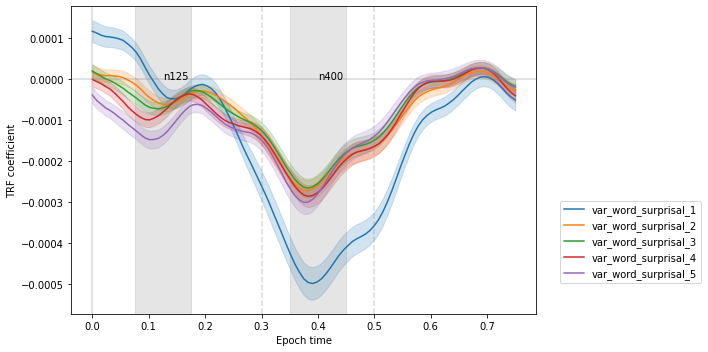

In [82]:
f, ax = plt.subplots(figsize=(10, 5))
plot_trf_coefficients(coef_agg_df, errorbar="se", predictor_match_patterns=[test_features[0]], ax=ax)

for troi, tstart, tend, _ in temporal_rois:
    ax.axvspan(tstart, tend, alpha=0.2, color="gray")
    ax.text((tend + tstart) / 2, 0, troi)
    
None

## Test superlinear vs sublinear

In [83]:
surprisal_quantile_means = -df.groupby("recognition_quantile").word_surprisal.mean()
surprisal_quantile_means

recognition_quantile
0    7.395496
1    4.065136
2    2.393407
3    1.184860
4    0.323735
Name: word_surprisal, dtype: float32

In [84]:
df["word_probability"] = 2 ** df.word_surprisal
probability_quantile_means = df.groupby("recognition_quantile").word_probability.mean()
probability_quantile_means

recognition_quantile
0    0.010856
1    0.064426
2    0.198275
3    0.448112
4    0.807958
Name: word_probability, dtype: float32

In [85]:
roi_df = {}

for label, tstart, tend, agg in temporal_rois:
    sub_comb_df = coef_agg_df[coef_agg_df.epoch_time.between(tstart, tend)]
    roi_df[label] = sub_comb_df.loc[sub_comb_df.groupby(["subject", "sensor", "predictor_name", "quantile"]).coef.agg(agg)]
    
roi_df = pd.concat(roi_df, names=["toi"])
roi_df["mean_surprisal"] = roi_df["quantile"].map(surprisal_quantile_means)
roi_df["mean_probability"] = roi_df["quantile"].map(probability_quantile_means)
roi_df

base_predictor subject  lag  epoch_time  sensor  quantile  \
toi                                                                             
n125 1009    var_recognition_onset       1   21    0.164062       0         0   
     1010    var_recognition_onset       1   21    0.164062       0         1   
     1011    var_recognition_onset       1   21    0.164062       0         2   
     964     var_recognition_onset       1   20    0.156250       0         3   
     1013    var_recognition_onset       1   21    0.164062       0         4   
...                            ...     ...  ...         ...     ...       ...   
n400 262939     var_word_surprisal       9   45    0.351562       7         0   
     262940     var_word_surprisal       9   45    0.351562       7         1   
     262941     var_word_surprisal       9   45    0.351562       7         2   
     262942     var_word_surprisal       9   45    0.351562       7         3   
     262943     var_word_surprisal       9   45    0.351562       7         4   

                 coef           predictor_name  mean_surprisal  \
toi                                                              
n125 1009   -0.000045  var_recognition_onset_1        7.395496   
     1010   -0.000100  var_recognition_onset_2        4.065136   
     1011   -0.000075  var_recognition_onset_3        2.393407   
     964    -0.000037  var_recognition_onset_4        1.184860   
     1013   -0.000108  var_recognition_onset_5        0.323735   
...               ...                      ...             ...   
n400 262939 -0.000915     var_word_surprisal_1        7.395496   
     262940 -0.000595     var_word_surprisal_2        4.065136   
     262941 -0.000546     var_word_surprisal_3        2.393407   
     262942 -0.000651     var_word_surprisal_4        1.184860   
     262943 -0.000729     var_word_surprisal_5        0.323735   

             mean_probability  
toi                            
n125 1009            0.010856  
     1010            0.064426  
     1011            0.198275  
     964             0.448112  
     1013            0.807958  
...                       ...  
n400 262939          0.010856  
     262940          0.064426  
     262941          0.198275  
     262942          0.448112  
     262943          0.807958  

[4560 rows x 10 columns]

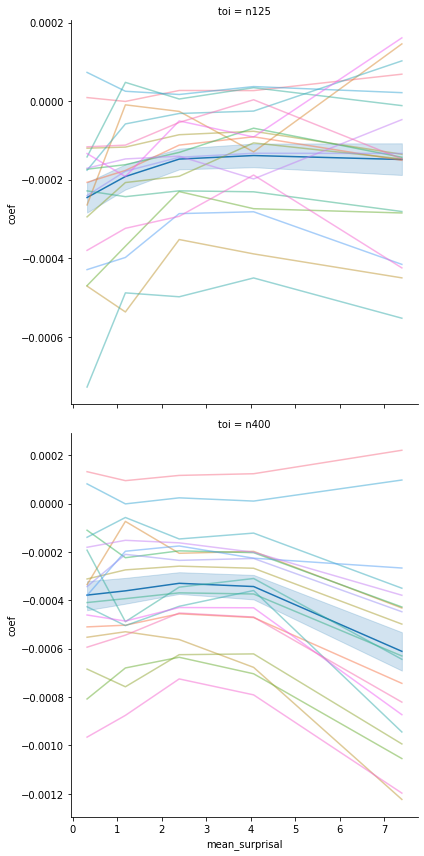

In [86]:
# g = sns.lmplot(data=roi_df.reset_index(), x="mean_surprisal", y="coef", row="toi", hue="subject", scatter=False,
#                line_kws={"alpha": 0.2}, ci=None, height=6, aspect=2, facet_kws=dict(sharey=False))
g = sns.FacetGrid(data=roi_df[roi_df.base_predictor == "var_word_surprisal"].reset_index(), row="toi", height=6, aspect=1, sharey=False)
g.map_dataframe(sns.lineplot, "mean_surprisal", "coef")
g.map_dataframe(lambda **kwargs: sns.lineplot(data=kwargs["data"], x="mean_surprisal", y="coef", hue="subject",
                                              alpha=0.5, errorbar=None))

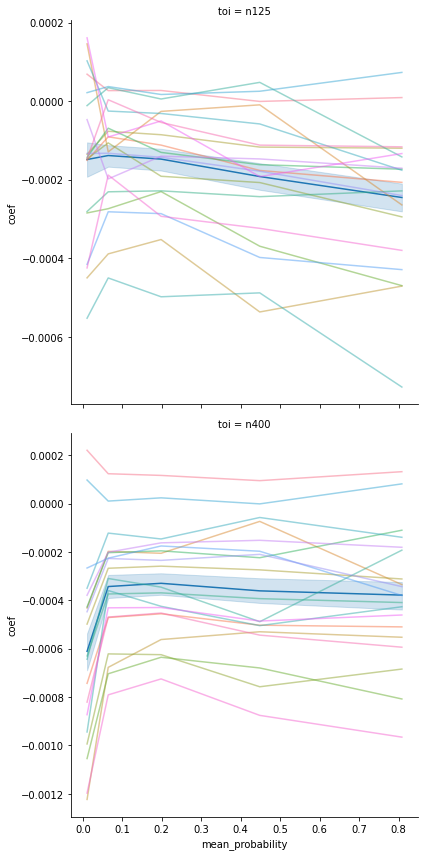

In [87]:
# g = sns.lmplot(data=roi_df.reset_index(), x="mean_surprisal", y="coef", row="toi", hue="subject", scatter=False,
#                line_kws={"alpha": 0.2}, ci=None, height=6, aspect=2, facet_kws=dict(sharey=False))
g = sns.FacetGrid(data=roi_df[roi_df.base_predictor == "var_word_surprisal"].reset_index(), row="toi", height=6, aspect=1, sharey=False)
g.map_dataframe(sns.lineplot, "mean_probability", "coef")
g.map_dataframe(lambda **kwargs: sns.lineplot(data=kwargs["data"], x="mean_probability", y="coef", hue="subject",
                                              alpha=0.5, errorbar=None))